In [66]:
import torch
import manga109api
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import patches
import os
from skimage import io, transform
from torchvision import transforms, utils

In [27]:
import manga109api
import numpy as np
manga109_root_dir = "Manga109_released_2021_12_30"
p = manga109api.Parser(root_dir=manga109_root_dir)
annotation = p.get_annotation(book="ARMS")
print(p.books[0])
print(annotation["page"][3]['body'])
book_name = p.books[0]
page_num = 3
annotation = p.get_annotation(book=book_name)
temp_bounding_boxes = annotation["page"][page_num]['body']
bounding_boxes = []
for b in temp_bounding_boxes:
    bounding_boxes.append([b['@xmin'], b['@ymin'], b['@xmax'], b['@ymax']])
bounding_boxes = np.array([bounding_boxes])
bounding_boxes = bounding_boxes.astype('float').reshape(-1, 4)
print(f'Book/Page : {book_name} page {page_num}')
print(f'Bounding boxes: {bounding_boxes}')

ARMS
[{'@id': '00000006', '@xmin': 1229, '@ymin': 709, '@xmax': 1352, '@ymax': 875, '@character': '00000003', 'type': 'body'}, {'@id': '00000008', '@xmin': 959, '@ymin': 820, '@xmax': 1172, '@ymax': 1089, '@character': '00000003', 'type': 'body'}, {'@id': '00000011', '@xmin': 499, '@ymin': 399, '@xmax': 646, '@ymax': 501, '@character': '00000010', 'type': 'body'}, {'@id': '00000012', '@xmin': 1202, '@ymin': 363, '@xmax': 1307, '@ymax': 545, '@character': '00000003', 'type': 'body'}, {'@id': '00000019', '@xmin': 273, '@ymin': 541, '@xmax': 741, '@ymax': 1093, '@character': '00000003', 'type': 'body'}]
Book/Page : ARMS page 3
Bounding boxes: [[1229.  709. 1352.  875.]
 [ 959.  820. 1172. 1089.]
 [ 499.  399.  646.  501.]
 [1202.  363. 1307.  545.]
 [ 273.  541.  741. 1093.]]


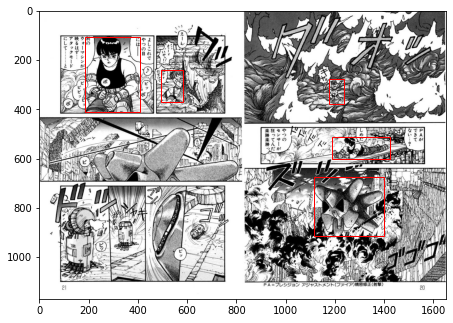

In [73]:
def show_characters(image, bounding_boxes, ax):
    """Show image with landmarks"""
    plt.imshow(image)
    if(np.sum(bounding_boxes) == 0):
        return
    for i, bbox in enumerate(bounding_boxes):
        xmin, ymin, xmax, ymax = bbox
        w = xmax - xmin
        h = ymax - ymin
        # add bounding boxes to the image
        box = patches.Rectangle(
            (xmin, ymin), w, h, edgecolor="red", facecolor="none"
        )

        ax.add_patch(box)
    plt.pause(0.001)  # pause a bit so that plots are updated

page_num = 9
page_file = f"{page_num:03d}.jpg"
img_name = os.path.join(manga109_root_dir, 'images', p.books[0],
                        page_file)
temp_bounding_boxes = annotation["page"][page_num]['body']
bounding_boxes = []
for b in temp_bounding_boxes:
    bounding_boxes.append([b['@xmin'], b['@ymin'], b['@xmax'], b['@ymax']])
bounding_boxes = np.array([bounding_boxes])
bounding_boxes = bounding_boxes.astype('float').reshape(-1, 4)
fig = plt.figure()
# add axes to the image
ax = fig.add_axes([0, 0, 1, 1])
show_characters(io.imread(img_name),
               bounding_boxes, ax)
plt.show()

In [50]:
class CharacterBoundingBoxes(Dataset):
    """Character Bounding Boxes dataset."""

    def __init__(self, parser, book_name, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.annotations = parser.get_annotation(book=book_name)
        self.root_dir = os.path.join(parser.root_dir,
                                'images', book_name)
        self.transform = transform

    def __len__(self):
        return len(self.annotations['page'])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        page_num = idx
        page_file = f"{page_num:03d}.jpg"
        img_name = os.path.join(self.root_dir,
                                page_file)
        image = io.imread(img_name)
        temp_bounding_boxes = annotation["page"][page_num]['body']
        bounding_boxes = []
        for b in temp_bounding_boxes:
            bounding_boxes.append([b['@xmin'], b['@ymin'], b['@xmax'], b['@ymax']])
        bounding_boxes = np.array(bounding_boxes)
        sample = {'image': image, 'bounding_boxes': bounding_boxes}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (1170, 1654, 3) (0,)
1 (1170, 1654, 3) (0,)
2 (1170, 1654, 3) (1, 4)


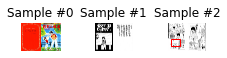

3 (1170, 1654, 3) (5, 4)


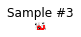

4 (1170, 1654, 3) (6, 4)


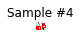

5 (1170, 1654, 3) (3, 4)


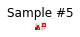

6 (1170, 1654, 3) (7, 4)


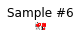

7 (1170, 1654, 3) (5, 4)


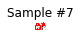

8 (1170, 1654, 3) (9, 4)


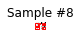

9 (1170, 1654, 3) (5, 4)


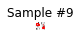

In [64]:
test_dataset = CharacterBoundingBoxes(parser=p, book_name=p.books[1])
fig = plt.figure(figsize=(10,10))
num_samples = 10

for i in range(len(test_dataset)):
    sample = test_dataset[i]

    print(i, sample['image'].shape, sample['bounding_boxes'].shape)

    ax = plt.subplot(1, num_samples, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_characters(sample['image'], sample['bounding_boxes'], ax = ax)

    if i == num_samples - 1:
        plt.show()
        break

In [68]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bounding_boxes = sample['image'], sample['bounding_boxes']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        if len(bounding_boxes > 0):
            bounding_boxes = bounding_boxes * [new_w / w, new_h / h, new_w / w, new_h / h]

        return {'image': img, 'bounding_boxes': bounding_boxes}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, bounding_boxes = sample['image'], sample['bounding_boxes']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        if len(bounding_boxes > 0):
            bounding_boxes = bounding_boxes - [left, top, left, top]

        return {'image': image, 'bounding_boxes': bounding_boxes}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bounding_boxes = sample['image'], sample['bounding_boxes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(bounding_boxes)}

In [69]:
transformed_dataset = CharacterBoundingBoxes(parser=p, book_name=p.books[1],
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([0])
1 torch.Size([3, 224, 224]) torch.Size([0])
2 torch.Size([3, 224, 224]) torch.Size([1, 4])
3 torch.Size([3, 224, 224]) torch.Size([5, 4])


In [70]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=0)


# Helper function to show a batch
def show_landmarks_batch(sample_batched, ax):
    """Show image with landmarks for a batch of samples."""
    images_batch, bounding_boxes_batch = \
            sample_batched['image'], sample_batched['bounding_boxes']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        for j, bbox in enumerate(bounding_boxes_batch[i]):
            xmin, ymin, xmax, ymax = bbox
            w = xmax - xmin
            h = ymax - ymin
            # add bounding boxes to the image
            box = patches.Rectangle(
                (xmin+ i * im_size + (i + 1) * grid_border_size, ymin+ grid_border_size), w, h, edgecolor="red", facecolor="none"
            )

            ax.add_patch(box)

        plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change ``num_workers`` to 0.

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        ax = fig.add_axes([0, 0, 1, 1])
        show_landmarks_batch(sample_batched, ax)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

RuntimeError: stack expects each tensor to be equal size, but got [7, 4] at entry 0 and [17, 4] at entry 2